In [1]:
import os
import sys
import timeit

import numpy

deep_root = 'DeepLearningTutorials/'
sys.path.insert(0, os.path.join(deep_root,'code'))

import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv

from logistic_sgd import LogisticRegression, load_data
from mlp import HiddenLayer


Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [4]:
from convolutional_mlp import  LeNetConvPoolLayer

##Model Design and Training

In [5]:
learning_rate=0.1
n_epochs=10
dataset='mnist.pkl.gz'
nkerns=[20, 50]
batch_size=500
rng = numpy.random.RandomState(23455)

In [6]:
datasets = load_data(dataset)

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

# compute number of minibatches for training, validation and testing
n_train_batches = train_set_x.get_value(borrow=True).shape[0]
n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
n_test_batches = test_set_x.get_value(borrow=True).shape[0]
n_train_batches /= batch_size
n_valid_batches /= batch_size
n_test_batches /= batch_size

... loading data


In [10]:
test_set_y

Elemwise{Cast{int32}}.0

In [15]:
"""
def evaluate_lenet5(learning_rate=0.1, n_epochs=200,
                    dataset='mnist.pkl.gz',
                    nkerns=[20, 50], batch_size=500):
"""    
""" Demonstrates lenet on MNIST dataset

:type learning_rate: float
:param learning_rate: learning rate used (factor for the stochastic
                      gradient)

:type n_epochs: int
:param n_epochs: maximal number of epochs to run the optimizer

:type dataset: string
:param dataset: path to the dataset used for training /testing (MNIST here)

:type nkerns: list of ints
:param nkerns: number of kernels on each layer
"""


# allocate symbolic variables for the data
index = T.lscalar()  # index to a [mini]batch

# start-snippet-1
x = T.matrix('x')   # the data is presented as rasterized images
y = T.ivector('y')  # the labels are presented as 1D vector of
                    # [int] labels

######################
# BUILD ACTUAL MODEL #
######################
print '... building the model'

# Reshape matrix of rasterized images of shape (batch_size, 28 * 28)
# to a 4D tensor, compatible with our LeNetConvPoolLayer
# (28, 28) is the size of MNIST images.
layer0_input = x.reshape((batch_size, 1, 28, 28))

# Construct the first convolutional pooling layer:
# filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
# maxpooling reduces this further to (24/2, 24/2) = (12, 12)
# 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
layer0 = LeNetConvPoolLayer(
    rng,
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 5, 5),
    poolsize=(2, 2)
)

# Construct the second convolutional pooling layer
# filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
# maxpooling reduces this further to (8/2, 8/2) = (4, 4)
# 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
layer1 = LeNetConvPoolLayer(
    rng,
    input=layer0.output,
    image_shape=(batch_size, nkerns[0], 12, 12),
    filter_shape=(nkerns[1], nkerns[0], 5, 5),
    poolsize=(2, 2)
)

# the HiddenLayer being fully-connected, it operates on 2D matrices of
# shape (batch_size, num_pixels) (i.e matrix of rasterized images).
# This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
# or (500, 50 * 4 * 4) = (500, 800) with the default values.
layer2_input = layer1.output.flatten(2)

# construct a fully-connected sigmoidal layer
layer2 = HiddenLayer(
    rng,
    input=layer2_input,
    n_in=nkerns[1] * 4 * 4,
    n_out=500,
    activation=T.tanh
)

# classify the values of the fully-connected sigmoidal layer
layer3 = LogisticRegression(input=layer2.output, n_in=500, n_out=10)

# the cost we minimize during training is the NLL of the model
cost = layer3.negative_log_likelihood(y)

# create a function to compute the mistakes that are made by the model
test_model = theano.function(
    [index],
    layer3.errors(y),
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

validate_model = theano.function(
    [index],
    layer3.errors(y),
    givens={
        x: valid_set_x[index * batch_size: (index + 1) * batch_size],
        y: valid_set_y[index * batch_size: (index + 1) * batch_size]
    }
)

# create a list of all model parameters to be fit by gradient descent
params = layer3.params + layer2.params + layer1.params + layer0.params

# create a list of gradients for all model parameters
grads = T.grad(cost, params)

# train_model is a function that updates the model parameters by
# SGD Since this model has many parameters, it would be tedious to
# manually create an update rule for each model parameter. We thus
# create the updates list by automatically looping over all
# (params[i], grads[i]) pairs.
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size],
        y: train_set_y[index * batch_size: (index + 1) * batch_size]
    }
)
# end-snippet-1

###############
# TRAIN MODEL #
###############
print '... training'
# early-stopping parameters
patience = 10000  # look as this many examples regardless
patience_increase = 2  # wait this much longer when a new best is
                       # found
improvement_threshold = 0.995  # a relative improvement of this much is
                               # considered significant
validation_frequency = min(n_train_batches, patience / 2)
                              # go through this many
                              # minibatche before checking the network
                              # on the validation set; in this case we
                              # check every epoch

best_validation_loss = numpy.inf
best_iter = 0
test_score = 0.
start_time = timeit.default_timer()

epoch = 0
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in xrange(n_train_batches):

        iter = (epoch - 1) * n_train_batches + minibatch_index

        if iter % 100 == 0:
            print 'training @ iter = ', iter
        cost_ij = train_model(minibatch_index)

        if (iter + 1) % validation_frequency == 0:

            # compute zero-one loss on validation set
            validation_losses = [validate_model(i) for i
                                 in xrange(n_valid_batches)]
            this_validation_loss = numpy.mean(validation_losses)
            print('epoch %i, minibatch %i/%i, validation error %f %%' %
                  (epoch, minibatch_index + 1, n_train_batches,
                   this_validation_loss * 100.))

            # if we got the best validation score until now
            if this_validation_loss < best_validation_loss:

                #improve patience if loss improvement is good enough
                if this_validation_loss < best_validation_loss *  \
                   improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                # save best validation score and iteration number
                best_validation_loss = this_validation_loss
                best_iter = iter

                # test it on the test set
                test_losses = [
                    test_model(i)
                    for i in xrange(n_test_batches)
                ]
                test_score = numpy.mean(test_losses)
                print(('     epoch %i, minibatch %i/%i, test error of '
                       'best model %f %%') %
                      (epoch, minibatch_index + 1, n_train_batches,
                       test_score * 100.))

        if patience <= iter:
            done_looping = True
            break

end_time = timeit.default_timer()
print('Optimization complete.')
print('Best validation score of %f %% obtained at iteration %i, '
      'with test performance %f %%' %
      (best_validation_loss * 100., best_iter + 1, test_score * 100.))


... building the model
... training
training @ iter =  0
epoch 1, minibatch 100/100, validation error 9.230000 %
     epoch 1, minibatch 100/100, test error of best model 9.520000 %
training @ iter =  100
epoch 2, minibatch 100/100, validation error 6.180000 %
     epoch 2, minibatch 100/100, test error of best model 6.500000 %
training @ iter =  200
epoch 3, minibatch 100/100, validation error 4.640000 %
     epoch 3, minibatch 100/100, test error of best model 4.850000 %
training @ iter =  300
epoch 4, minibatch 100/100, validation error 3.500000 %
     epoch 4, minibatch 100/100, test error of best model 3.910000 %
training @ iter =  400
epoch 5, minibatch 100/100, validation error 3.020000 %
     epoch 5, minibatch 100/100, test error of best model 3.260000 %
training @ iter =  500
epoch 6, minibatch 100/100, validation error 2.780000 %
     epoch 6, minibatch 100/100, test error of best model 2.800000 %
training @ iter =  600
epoch 7, minibatch 100/100, validation error 2.470000 %

##Compile a test function

In [16]:
idx = T.lscalar()
predict_datum = theano.function(
    [idx],
    layer3.y_pred,
    givens={
        x: test_set_x[idx * batch_size: (idx + 1) * batch_size]
    }
)


In [17]:
result = []
for i in range(n_test_batches):
    result.append(predict_datum(i))

In [18]:
import numpy as np
result = np.hstack([predict_datum(i) for i in xrange(n_test_batches)])

##calculate accuracy

In [26]:
num_test_set = test_set_y.eval().shape[0]
idx_acc = [i for i in xrange(num_test_set) if result[i] == test_set_y.eval()[i] ]
acc = len(idx_acc) / float(num_test_set)

In [27]:
acc

0.9812

##Visualization

7


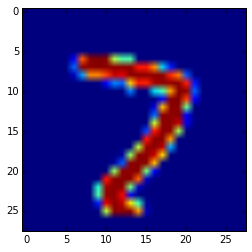

In [29]:
from __future__ import print_function
from IPython.html.widgets import interact, interactive, fixed
from IPython.html import widgets

import matplotlib.pyplot as plt
% pylab inline 

@interact (bar_idx=(0,num_test_set))
def viz(bar_idx):
    img = test_set_x.get_value(borrow=True)[bar_idx]
    a = numpy.reshape(img, [28,28])
    plt.imshow(a)
    print(result[bar_idx])